In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp
import jax.numpy.linalg as JLA

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
n = 128
m = 64
sigma = 0.1
p = 0.05
num_itr = 40

K = 200
adam_lr = 5e-5
max_inner = 20

A = np.random.randn(m, n)
eig, _ = LA.eig(A.T @ A)
gamma_opt = 1./max(eig)
A = jnp.array(A)

In [3]:
def mini_batch(K):
    seq = np.random.randn(n, K)
    support = np.random.binomial(1,p,size=(n, K))
    x = jnp.array(seq * support)
    y = A @ x + sigma * jnp.array(np.random.randn(m, K))
    return y, x

In [4]:
def softshrink(x, lam):
    return jnp.sign(x) * jnp.max(jnp.append(jnp.abs(x) - lam, 0))
vec_softshrink = jax.jit(jax.vmap(softshrink, in_axes=[-1, None], out_axes=-1))

In [5]:
def ISTA(max_itr, y):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= gamma_opt * A.T @ (A@x - y)
        x = vec_softshrink(x.reshape(1, -1), gamma_opt)
        x = x.reshape(n, K)
    return x

In [6]:
@jax.jit
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [7]:
def comp_mse(max_itr):
    y, x_org = mini_batch(K)
    x_hat = ISTA(max_itr, y)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [8]:
ISTA_mse = [float(jax.device_get(comp_mse(i+1)).real) for i in range(num_itr)]
df = pd.DataFrame()
df["Itaration"] = range(num_itr)
df["ISTA (fixed step size)"] = ISTA_mse

In [9]:
@partial(jax.jit, static_argnums=0)
def DU_ISTA(max_itr, y, eta, mu):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        x -= eta[i] * A.T@(A@x -y)
        x = vec_softshrink(x.reshape(1, -1), mu[i])
        x = x.reshape((n, K)).real
    return x

In [22]:
@partial(jax.jit, static_argnums=1)
def loss(x_org, max_itr, y, eta, mu):
    x_hat = DU_ISTA(max_itr, y, eta, mu)
    return jnp.sum(batch_get_dot(x_org - x_hat))/K

In [23]:
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(x_org, max_itr, y, step_num, opt_state1, opt_state2):
    tmp_eta = get_params1(opt_state1)
    tmp_mu = get_params2(opt_state2)
    value, grads = jax.value_and_grad(loss, argnums=-2)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state1 = opt_update1(step_num, grads, opt_state1)
    value, grads = jax.value_and_grad(loss, argnums=-1)(x_org, max_itr, y, tmp_eta, tmp_mu)
    new_opt_state2 = opt_update2(step_num, grads, opt_state2)
    return value, new_opt_state1, new_opt_state2

def train(eta, mu):
    opt_state1 = opt_init1(eta)
    opt_state2 = opt_init2(mu)
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            y, x_org = mini_batch(K)
            value, opt_state1, opt_state2 = step(x_org, itr+1, y, i, opt_state1, opt_state2)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params1(opt_state1), get_params2(opt_state2)

In [24]:
def comp_mse_DUGD(max_itr, eta, mu):
    y, x_org = mini_batch(K)
    return float(loss(x_org, max_itr, y, eta, mu))

In [25]:
eta_init = gamma_opt*jnp.ones(num_itr)
mu_init = gamma_opt*jnp.ones(num_itr)
eta_trained, mu_trained = train(eta_init, mu_init)

  0%|          | 0/40 [00:00<?, ?it/s]

loss:1.839298963546753  

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.5355815887451172 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.5410757064819336 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.5596706867218018 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.517789602279663 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.3358747959136963 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.1977527141571045 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.38322114944458 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.28880774974823 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.3430923223495483 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:1.0134357213974 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.9108724594116211 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.9750023484230042 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.8799667358398438 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.9085001349449158 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.8443092107772827 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.731044590473175 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.7622237801551819 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.6985417008399963 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.5673666000366211 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.5552796125411987 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.5356123447418213 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.5894371271133423 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.5595569610595703 

/opt/conda/lib/python3.11/site-packages/jax/_src/lax/lax.py:2690: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


loss:0.5284697413444519 

In [26]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, mu_trained) for i in range(num_itr)]
df["DU-ISTA"] = DUGD_mse

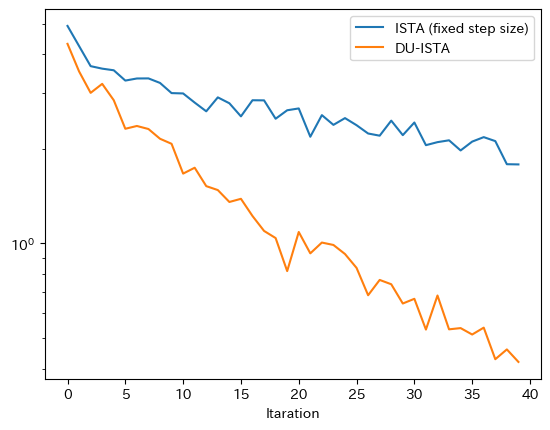

In [28]:
df.plot(df.columns[0], df.columns[1:3])
plt.yscale("log")

In [29]:
df["eta"] = eta_trained.real
df["mu"] = mu_trained.real

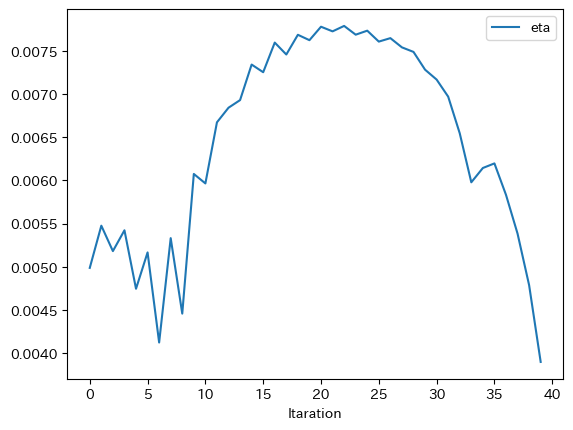

In [30]:
df.plot(df.columns[0], "eta");

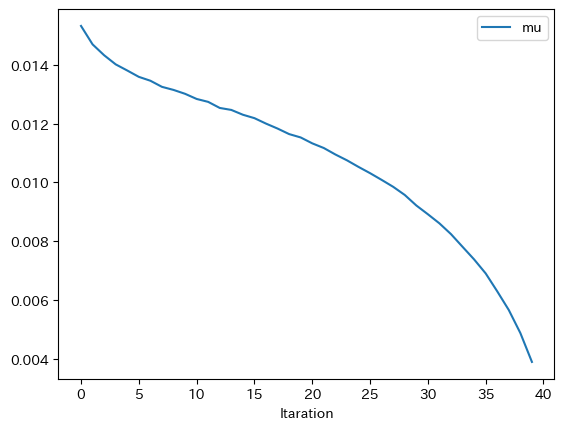

In [31]:
df.plot(df.columns[0], "mu");